/tmp/ipykernel_16434/2682984553.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '129.25212161689777' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'allocation_score'] = score


Dataset generated with 5000 records.
Loading existing dataset...

Training models...
Allocation Score R² Score: 0.4120
Allocation Score RMSE: 41.3405
Bay Assignment Accuracy: 0.3730
Slot Assignment Accuracy: 0.1900

Initializing Q-learning environment...

Training Q-learning agent...
Episode: 0, Epsilon: 0.99
Episode: 1000, Epsilon: 0.01
Episode: 2000, Epsilon: 0.01
Episode: 3000, Epsilon: 0.01
Episode: 4000, Epsilon: 0.01
Episode: 5000, Epsilon: 0.01
Episode: 6000, Epsilon: 0.01
Episode: 7000, Epsilon: 0.01
Episode: 8000, Epsilon: 0.01
Episode: 9000, Epsilon: 0.01

Initializing Smart Parking System...

Testing Smart Parking System with example vehicles...

High Priority Government Vehicle Allocation:
Status: Allocated
Bay Assigned: 2
Slot Assigned: 2
Allocation Score: 209.06
Q-value: 491.72
Reward: 108.00
Parking Lot Status:
Legend: [Empty: □, Occupied: ■]

Bay 1: ■ ■ □ ■ □ □ ■ □ ■ ■ 
Bay 2: ■ ■ ■ ■ ■ ■ ■ ■ ■ ■ 
Bay 3: ■ ■ ■ ■ ■ ■ ■ ■ □ ■ 
Bay 4: ■ □ ■ ■ ■ ■ □ □ ■ ■ 


Regular Private

/home/kupamakunura/miniconda3/envs/sp/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/kupamakunura/miniconda3/envs/sp/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


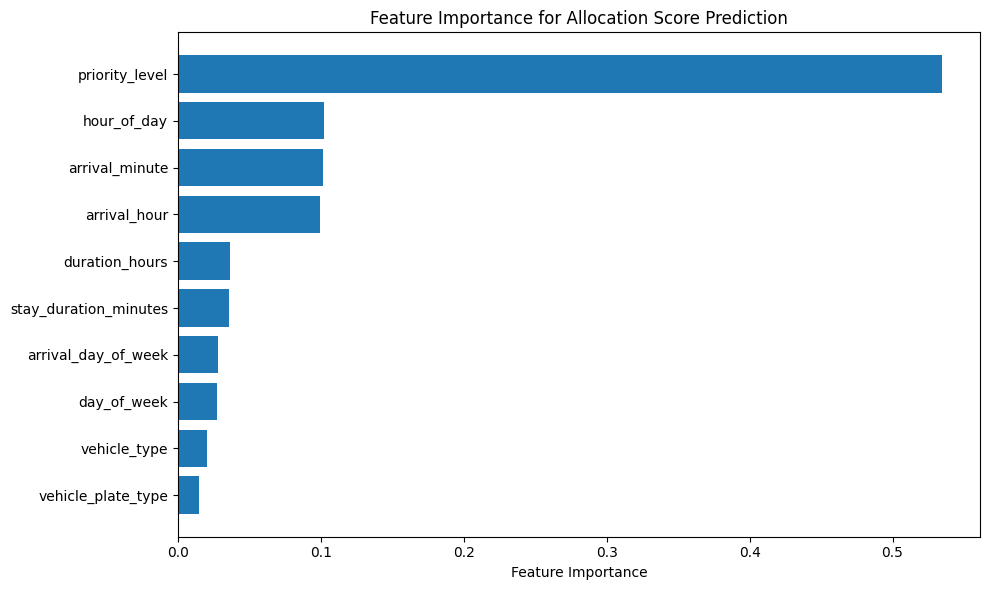

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta
import pickle
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Part 1: Generate a realistic synthetic dataset
def generate_parking_dataset(num_records=5000):
    # Define possible values for categorical features
    vehicle_plate_types = ['Private', 'Public', 'Govt']  # 0, 1, 2
    vehicle_types = ['Car', 'Truck', 'Motorcycle']  # 0, 1, 2
    
    # Generate random data
    data = {
        'vehicle_plate_num': [f'ABC{np.random.randint(1000, 9999)}' for _ in range(num_records)],
        'vehicle_plate_type': np.random.choice(vehicle_plate_types, num_records),
        'vehicle_type': np.random.choice(vehicle_types, num_records),
    }
    
    # Create a DataFrame
    df = pd.DataFrame(data)
    
    # Generate arrival times (distribute across a week with realistic patterns)
    start_date = datetime(2023, 5, 1)  # Monday
    arrival_times = []
    
    for _ in range(num_records):
        # Randomly select a day in the week (0-6: Monday to Sunday)
        day_offset = int(np.random.randint(0, 7))
        
        # Generate hour with peak hours more likely (8-10am and 4-6pm)
        if np.random.random() < 0.6:  # 60% in peak hours
            peak_period = np.random.choice(['morning', 'evening'])
            if peak_period == 'morning':
                hour = np.random.choice([7, 8, 9, 10], p=[0.1, 0.3, 0.4, 0.2])
            else:
                hour = np.random.choice([16, 17, 18, 19], p=[0.2, 0.4, 0.3, 0.1])
        else:
            hour = np.random.choice(range(6, 22))  # Regular hours between 6am and 10pm
            
        # Generate minute
        minute = int(np.random.randint(0, 60))
        
        # Create the arrival timestamp
        arrival_time = start_date + timedelta(days=day_offset, hours=int(hour), minutes=minute)
        arrival_times.append(arrival_time)
    
    df['arrival_time'] = arrival_times
    
    # Generate stay durations (in hours) with realistic patterns
    # Most stays are 1-3 hours, with some longer stays
    stay_duration_hours = []
    for vehicle_type in df['vehicle_type']:
        if vehicle_type == 'Car':
            duration = np.random.choice([1, 2, 3, 4, 5, 8], p=[0.2, 0.3, 0.2, 0.15, 0.1, 0.05])
        elif vehicle_type == 'Truck':
            duration = np.random.choice([1, 2, 3, 4, 6], p=[0.1, 0.2, 0.3, 0.25, 0.15])
        else:  # Motorcycle
            duration = np.random.choice([1, 2, 3, 4], p=[0.4, 0.3, 0.2, 0.1])
            
        stay_duration_hours.append(duration)
    
    df['duration_hours'] = stay_duration_hours
    
    # Calculate departure times
    df['departure_time'] = df['arrival_time'] + pd.to_timedelta(df['duration_hours'], unit='h')
    
    # Extract time features
    df['day_of_week'] = df['arrival_time'].dt.dayofweek
    df['hour_of_day'] = df['arrival_time'].dt.hour
    df['arrival_hour'] = df['arrival_time'].dt.hour
    df['arrival_minute'] = df['arrival_time'].dt.minute
    df['arrival_day_of_week'] = df['arrival_time'].dt.dayofweek
    df['stay_duration_minutes'] = df['duration_hours'] * 60
    
    # Assign priority levels (0-3) based on vehicle type and plate type
    # Higher priority for govt vehicles and lower for private
    df['priority_level'] = 0
    
    for i, row in df.iterrows():
        base_priority = 0
        
        # Vehicle plate type priority
        if row['vehicle_plate_type'] == 'Govt':
            base_priority += 2
        elif row['vehicle_plate_type'] == 'Public':
            base_priority += 1
            
        # Vehicle type priority adjustments
        if row['vehicle_type'] == 'Truck':
            base_priority = max(0, base_priority - 1)  # Trucks lower priority due to size
        
        # Cap priority between 0-3
        df.loc[i, 'priority_level'] = min(3, base_priority)
    
    # Assign bay and slot based on a rule-based approach initially
    # (we'll replace these with ML predictions later)
    df['bay_assigned'] = np.random.randint(1, 5, size=num_records)  # 1-4
    df['slot_assigned'] = np.random.randint(1, 11, size=num_records)  # 1-10
    
    # Create an allocation score that depends on multiple factors:
    # - Higher score for better bay/slot locations
    # - Time of day affects score (peak hours get premium scores)
    # - Priority level affects score
    # - Duration affects score (shorter stays might get premium spots)
    
    df['allocation_score'] = 0
    
    for i, row in df.iterrows():
        base_score = 50  # Base score
        
        # Location factor (lower bay/slot numbers are better)
        location_score = (5 - row['bay_assigned']) * 10 + (11 - row['slot_assigned']) * 5
        
        # Time factor
        hour = row['hour_of_day']
        if hour in [8, 9, 17, 18]:  # Peak hours
            time_factor = 1.5
        elif hour in [7, 10, 16, 19]:  # Near peak
            time_factor = 1.2
        else:
            time_factor = 1.0
            
        # Priority factor
        priority_factor = 1 + row['priority_level'] * 0.5
        
        # Duration factor (shorter stays might get better spots)
        duration_factor = max(0.8, 1.2 - row['duration_hours'] * 0.05)
        
        # Final score with some randomness
        score = base_score + location_score * time_factor * priority_factor * duration_factor
        score += np.random.normal(0, 10)  # Add some noise
        
        df.loc[i, 'allocation_score'] = score
    
    # Convert categorical variables to numeric for model training
    df['vehicle_plate_type'] = df['vehicle_plate_type'].map({'Private': 0, 'Public': 1, 'Govt': 2})
    df['vehicle_type'] = df['vehicle_type'].map({'Car': 0, 'Truck': 1, 'Motorcycle': 2})
    
    return df

# Generate and save the dataset
parking_data = generate_parking_dataset(5000)
parking_data.to_csv('parking_data.csv', index=False)
print(f"Dataset generated with {len(parking_data)} records.")

# Part 2: Train ML Models
def train_models(parking_data):
    # Define features
    features = [
        "vehicle_plate_type",
        "vehicle_type",
        "day_of_week",
        "hour_of_day",
        "duration_hours",
        "priority_level",
        "arrival_hour",
        "arrival_minute",
        "arrival_day_of_week",
        "stay_duration_minutes"
    ]
    
    target = "allocation_score"
    
    X = parking_data[features]
    y = parking_data[target]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create pipeline with scaling and GradientBoostingRegressor for score prediction
    score_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('gb_regressor', GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42))
    ])
    
    # Train the allocation score model
    score_pipeline.fit(X_train, y_train)
    score_pred = score_pipeline.predict(X_test)
    print(f"Allocation Score R² Score: {r2_score(y_test, score_pred):.4f}")
    print(f"Allocation Score RMSE: {np.sqrt(mean_squared_error(y_test, score_pred)):.4f}")
    
    # Create models for bay and slot assignment
    location_features = features + ["allocation_score"]
    X_loc = parking_data[location_features]
    y_bay = parking_data["bay_assigned"]
    y_slot = parking_data["slot_assigned"]
    
    X_loc_train, X_loc_test, y_bay_train, y_bay_test, y_slot_train, y_slot_test = train_test_split(
        X_loc, y_bay, y_slot, test_size=0.2, random_state=42
    )
    
    # Model for bay assignment
    bay_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    bay_model.fit(X_loc_train, y_bay_train)
    bay_pred = bay_model.predict(X_loc_test).round().astype(int)
    bay_accuracy = np.mean(bay_pred == y_bay_test)
    print(f"Bay Assignment Accuracy: {bay_accuracy:.4f}")
    
    # Model for slot assignment
    slot_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    slot_model.fit(X_loc_train, y_slot_train)
    slot_pred = slot_model.predict(X_loc_test).round().astype(int)
    slot_accuracy = np.mean(slot_pred == y_slot_test)
    print(f"Slot Assignment Accuracy: {slot_accuracy:.4f}")
    
    # Visualize feature importance for the score model
    feature_importance = score_pipeline.named_steps['gb_regressor'].feature_importances_
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance for Allocation Score Prediction')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    
    return score_pipeline, bay_model, slot_model

# Part 3: Define Q-Learning Environment
class ParkingEnvironment:
    def __init__(self, num_bays=4, slots_per_bay=10):
        self.num_bays = num_bays
        self.slots_per_bay = slots_per_bay
        self.state_size = self.num_bays * self.slots_per_bay
        self.action_size = self.state_size
        self.q_table = np.zeros((4, 24, self.action_size))  # 4 priority levels, 24 hours
        self.parking_lot = np.zeros((num_bays, slots_per_bay))  # 0 = empty, 1 = occupied
        self.current_hour = 0  # Default hour
        
    def reset(self, occupancy_rate=0.5, hour=None):
        # Initialize with some random occupancy
        self.parking_lot = np.random.choice(
            [0, 1], 
            size=(self.num_bays, self.slots_per_bay), 
            p=[1-occupancy_rate, occupancy_rate]
        )
        self.state = self.parking_lot.flatten()
        # Set current hour for time-dependent decisions
        self.current_hour = hour if hour is not None else np.random.randint(0, 24)
        return self.state
    
    def get_available_spaces(self):
        # Return indices of available spaces
        return np.where(self.state == 0)[0]
    
    def step(self, action, priority):
        reward = -100  # Default negative reward for invalid actions
        done = False
        
        # Check if the action (parking space) is available
        if 0 <= action < self.state_size and self.state[action] == 0:
            bay = action // self.slots_per_bay
            slot = action % self.slots_per_bay
            
            # Reward structure with time factor:
            # - Higher priority vehicles get better rewards for closer spots
            # - Lower slots (closer to entrance) are more valuable
            # - Different bays may have different base values
            # - Time-of-day affects reward (e.g., premium spots more valuable during peak hours)
            bay_value = 10 - bay  # Bay 0 is most valuable
            slot_value = self.slots_per_bay - slot  # Slot 0 is most valuable
            priority_factor = priority + 1
            
            # Time factor - peak hours (8-10am, 5-7pm) get higher rewards for good spots
            peak_hours = [8, 9, 10, 17, 18, 19]
            time_factor = 1.5 if self.current_hour in peak_hours else 1.0
            
            # Calculate reward
            reward = priority_factor * (bay_value + slot_value) * time_factor
            
            # Mark the spot as occupied
            self.state[action] = 1
            self.parking_lot[bay, slot] = 1
            
        # Check if the parking lot is full
        if np.all(self.state == 1):
            done = True
            
        return self.state, reward, done
    
    def get_bay_slot(self, action):
        bay = action // self.slots_per_bay
        slot = action % self.slots_per_bay
        return bay + 1, slot + 1  # Adding 1 to match 1-based indexing

# Part 4: Train Q-learning
def train_q_learning(env, num_episodes=10000):
    learning_rate = 0.1
    discount_factor = 0.95
    epsilon = 1.0
    epsilon_decay = 0.995
    min_epsilon = 0.01
    
    for episode in range(num_episodes):
        # For each episode, randomly select an hour to simulate different times of day
        current_hour = np.random.randint(0, 24)
        state = env.reset(hour=current_hour)
        done = False
        priority = np.random.randint(0, 4)  # Random priority for this episode
        
        while not done:
            # Get available spaces
            available_spaces = env.get_available_spaces()
            
            if len(available_spaces) == 0:
                break  # No available spaces
                
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                # Random action from available spaces
                action = np.random.choice(available_spaces)
            else:
                # Get Q-values for current priority and hour
                priority_hour_q_values = env.q_table[priority, current_hour]
                
                # Filter to available spaces
                available_q_values = [priority_hour_q_values[action] for action in available_spaces]
                
                # Select best action
                best_idx = np.argmax(available_q_values)
                action = available_spaces[best_idx]
            
            # Take action
            next_state, reward, done = env.step(action, priority)
            
            # Q-learning update
            if not done and len(env.get_available_spaces()) > 0:
                # Get best next action
                next_available_spaces = env.get_available_spaces()
                next_available_q_values = [env.q_table[priority, current_hour, action] for action in next_available_spaces]
                best_next_idx = np.argmax(next_available_q_values)
                best_next_action = next_available_spaces[best_next_idx]
                
                # Q-value update
                td_target = reward + discount_factor * env.q_table[priority, current_hour, best_next_action]
            else:
                td_target = reward
                
            td_error = td_target - env.q_table[priority, current_hour, action]
            env.q_table[priority, current_hour, action] += learning_rate * td_error
            
            state = next_state
        
        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        
        if episode % 1000 == 0:
            print(f"Episode: {episode}, Epsilon: {epsilon:.2f}")
    
    # Save Q-table
    np.save('q_table_time_aware.npy', env.q_table)
    
    return env

# Part 5: Smart Parking System Class
class SmartParkingSystem:
    def __init__(self, score_model, bay_model, slot_model, env):
        self.score_model = score_model
        self.bay_model = bay_model
        self.slot_model = slot_model
        self.env = env
        
    def predict_allocation_score(self, vehicle_data):
        # Extract features including temporal ones
        if isinstance(vehicle_data.get('arrival_time'), str):
            arrival_time = datetime.strptime(vehicle_data.get('arrival_time', '2023-05-01 08:00:00'), 
                                            '%Y-%m-%d %H:%M:%S')
            departure_time = datetime.strptime(vehicle_data.get('departure_time', '2023-05-01 12:00:00'), 
                                            '%Y-%m-%d %H:%M:%S')
        else:
            arrival_time = vehicle_data.get('arrival_time', datetime.now())
            departure_time = vehicle_data.get('departure_time', arrival_time + timedelta(hours=2))
        
        # Calculate time features
        arrival_hour = arrival_time.hour
        arrival_minute = arrival_time.minute
        arrival_day_of_week = arrival_time.weekday()
        stay_duration_minutes = (departure_time - arrival_time).total_seconds() / 60
        
        features = np.array([[
            vehicle_data.get('vehicle_plate_type', 0), 
            vehicle_data.get('vehicle_type', 0),
            vehicle_data.get('day_of_week', arrival_day_of_week),
            vehicle_data.get('hour_of_day', arrival_hour),
            vehicle_data.get('duration_hours', stay_duration_minutes/60),
            vehicle_data.get('priority_level', 0),
            arrival_hour,
            arrival_minute,
            arrival_day_of_week,
            stay_duration_minutes
        ]])
        
        # Predict allocation score
        predicted_score = self.score_model.predict(features)[0]
        return predicted_score
    
    def allocate_parking(self, vehicle_data):
        # First, predict the allocation score
        predicted_score = self.predict_allocation_score(vehicle_data)
        
        # Get priority level and time
        priority = vehicle_data.get('priority_level', 0)
        
        # Get current hour from the vehicle data or use a default
        if isinstance(vehicle_data.get('arrival_time'), str):
            current_hour = vehicle_data.get('hour_of_day', 
                                   datetime.strptime(vehicle_data.get('arrival_time', '2023-05-01 08:00:00'), 
                                                   '%Y-%m-%d %H:%M:%S').hour)
        else:
            current_hour = vehicle_data.get('hour_of_day', 
                                vehicle_data.get('arrival_time', datetime.now()).hour)
        
        # Reset environment with current hour and realistic occupancy
        # Higher occupancy during peak hours
        if current_hour in [8, 9, 17, 18]:  # Peak hours
            occupancy_rate = 0.7
        elif current_hour in [7, 10, 16, 19]:  # Near peak
            occupancy_rate = 0.5
        else:
            occupancy_rate = 0.3
            
        self.env.reset(occupancy_rate=occupancy_rate, hour=current_hour)
        
        # Use Q-learning for decision
        available_spaces = self.env.get_available_spaces()
        
        if len(available_spaces) == 0:
            return {'status': 'Parking full', 'allocation_score': predicted_score}
        
        # Use Q-table to select best action for this priority level and hour
        priority_hour_q_values = self.env.q_table[priority, current_hour]
        
        # Filter Q-values to only consider available spaces
        available_q_values = [(action, priority_hour_q_values[action]) for action in available_spaces]
        
        # Sort by Q-value (highest first)
        sorted_actions = sorted(available_q_values, key=lambda x: x[1], reverse=True)
        best_action = sorted_actions[0][0]
        
        # Take the action
        _, reward, _ = self.env.step(best_action, priority)
        
        # Get bay and slot numbers
        bay, slot = self.env.get_bay_slot(best_action)
        
        # Format arrival_time for output
        if isinstance(vehicle_data.get('arrival_time'), str):
            allocation_time = vehicle_data.get('arrival_time')
        else:
            allocation_time = vehicle_data.get('arrival_time', datetime.now()).strftime('%Y-%m-%d %H:%M:%S')
            
        return {
            'status': 'Allocated',
            'bay_assigned': bay,
            'slot_assigned': slot,
            'priority_level': priority,
            'allocation_score': predicted_score,
            'q_value': sorted_actions[0][1],
            'reward': reward,
            'allocation_time': allocation_time,
            'parking_map': self.visualize_parking_map()
        }
    
    def visualize_parking_map(self):
        """Generate a text representation of the current parking lot state"""
        result = "Parking Lot Status:\n"
        result += "Legend: [Empty: □, Occupied: ■]\n\n"
        
        for bay in range(self.env.num_bays):
            result += f"Bay {bay+1}: "
            for slot in range(self.env.slots_per_bay):
                if self.env.parking_lot[bay, slot] == 0:
                    result += "□ "  # Empty
                else:
                    result += "■ "  # Occupied
            result += "\n"
            
        return result

# Main execution
if __name__ == "__main__":
    # Generate and load data
    try:
        parking_data = pd.read_csv('parking_data.csv')
        print("Loading existing dataset...")
    except:
        parking_data = generate_parking_dataset(5000)
        parking_data.to_csv('parking_data.csv', index=False)
        print("Generated new dataset...")
    
    # Train models
    print("\nTraining models...")
    score_model, bay_model, slot_model = train_models(parking_data)
    
    # Save models
    with open('score_model.pkl', 'wb') as f:
        pickle.dump(score_model, f)
    with open('bay_model.pkl', 'wb') as f:
        pickle.dump(bay_model, f)
    with open('slot_model.pkl', 'wb') as f:
        pickle.dump(slot_model, f)
    
    # Initialize environment
    print("\nInitializing Q-learning environment...")
    env = ParkingEnvironment(num_bays=4, slots_per_bay=10)
    
    # Train Q-learning
    print("\nTraining Q-learning agent...")
    env = train_q_learning(env, num_episodes=10000)
    
    # Initialize smart parking system
    print("\nInitializing Smart Parking System...")
    smart_parking = SmartParkingSystem(score_model, bay_model, slot_model, env)
    
    # Example usage
    print("\nTesting Smart Parking System with example vehicles...")
    
    # Example 1: High priority government vehicle during peak hour
    test_vehicle1 = {
        'vehicle_plate_num': 'GOV1234', 
        'vehicle_plate_type': 2,  # Govt
        'vehicle_type': 0,  # Car
        'day_of_week': 1,  # Tuesday
        'hour_of_day': 8,  # Morning peak
        'duration_hours': 2, 
        'priority_level': 3,  # Highest priority
        'arrival_time': '2023-05-02 08:30:00',
        'departure_time': '2023-05-02 10:30:00'
    }
    
    allocation1 = smart_parking.allocate_parking(test_vehicle1)
    print("\nHigh Priority Government Vehicle Allocation:")
    print(f"Status: {allocation1['status']}")
    print(f"Bay Assigned: {allocation1['bay_assigned']}")
    print(f"Slot Assigned: {allocation1['slot_assigned']}")
    print(f"Allocation Score: {allocation1['allocation_score']:.2f}")
    print(f"Q-value: {allocation1['q_value']:.2f}")
    print(f"Reward: {allocation1['reward']:.2f}")
    print(allocation1['parking_map'])
    
    # Example 2: Regular private vehicle during off-peak
    test_vehicle2 = {
        'vehicle_plate_num': 'PVT5678', 
        'vehicle_plate_type': 0,  # Private
        'vehicle_type': 0,  # Car
        'day_of_week': 3,  # Thursday
        'hour_of_day': 14,  # Afternoon off-peak
        'duration_hours': 4, 
        'priority_level': 0,  # Lowest priority
        'arrival_time': '2023-05-04 14:15:00',
        'departure_time': '2023-05-04 18:15:00'
    }
    
    allocation2 = smart_parking.allocate_parking(test_vehicle2)
    print("\nRegular Private Vehicle Allocation:")
    print(f"Status: {allocation2['status']}")
    print(f"Bay Assigned: {allocation2['bay_assigned']}")
    print(f"Slot Assigned: {allocation2['slot_assigned']}")
    print(f"Allocation Score: {allocation2['allocation_score']:.2f}")
    print(f"Q-value: {allocation2['q_value']:.2f}")
    print(f"Reward: {allocation2['reward']:.2f}")
    print(allocation2['parking_map'])
    
    print("\nSmart Parking System is ready for use!")